# Titre du projet ( a décider)

## Sommaire

1. Number of games by genre.
2. Most played games.
3. Correlation between release date and ~reviews/plays.

## Introduction

Ce projet a pour but d'analyser statistiquement une base de données de jeux vidéo, en répondant à des questions  sur leurs caractéristiques, leur popularité et leur évolution dans le temps. sur un large ensemble. Puis d’en extraire des informations clés sur leurs genres, leur popularité, et leur évolution temporelle ???.

In [1]:
# Install dependencies

#!pip install pandas matplotlib ipywidgets kaggle

1. Number of games by genre.
We use "Genres" columns.

In [2]:
# Loading data
import os
import pandas as pd

file_path = "Datasets/Data/backloggd_games.csv"

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print(df.shape) # row and columns
    print(df.columns) # name/index
    df.head() # Preview

else:
    print("The file does not exist. Check the path or place the file in the correct location")

(60000, 14)
Index(['Unnamed: 0', 'Title', 'Release_Date', 'Developers', 'Summary',
       'Platforms', 'Genres', 'Rating', 'Plays', 'Playing', 'Backlogs',
       'Wishlist', 'Lists', 'Reviews'],
      dtype='object')


In [3]:
# Remove missing values, convert to string, and clean characters like [], '
all_genres = df['Genres'].dropna().astype(str).str.replace(r'[\[\]\']', '', regex=True)

# Split genres by comma, explode into rows, and strip whitespace
all_genres = all_genres.str.split(',').explode().str.strip()


# We remove empty genres 
all_genres = all_genres[all_genres != ""]


In [4]:
# Counting occurrences
genre_counts = all_genres.value_counts()
print("Number of games by genre :\n", genre_counts.head(10))

Number of games by genre :
 Genres
Adventure    19368
Indie        16816
RPG           9234
Simulator     8050
Strategy      7766
Shooter       7258
Puzzle        6935
Platform      6126
Arcade        5603
Sport         3912
Name: count, dtype: int64


In [51]:
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interactive_output, VBox
from IPython.display import display 

# Widget to select how many genres to display
top_n_slider = IntSlider(value=10, min=1, max=23, step=1, description='Top N:')

# Graphical
def plot_top_n(n):
    plt.figure(figsize=(12, 6))
    genre_counts.head(n).plot(kind='bar')
    plt.title(f"Top {n} Game Genres")
    plt.xlabel("Genre")
    plt.ylabel("Number of games")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Binding and display
display(VBox([top_n_slider, interactive_output(plot_top_n, {'n': top_n_slider})]))

2. Most played games.
We use "Plays" and "Title" columns.

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert K and M abbreviations to integers
def parse_play_count(x):
    x = str(x).replace(',', '').strip().upper()
    if x.endswith('K'):
        return int(float(x[:-1]) * 1_000)
    elif x.endswith('M'):
        return int(float(x[:-1]) * 1_000_000)
    elif x.isdigit():
        return int(x)
    else:
        return None  # to invalid values

# Parsing
df['Cumulative_number_plays'] = df['Plays'].apply(parse_play_count)

# Sort games by number of plays
top_played = df[['Title', 'Cumulative_number_plays']].sort_values(by='Cumulative_number_plays', ascending=False).head(10)
print("\nTop 10 most played games:")
print(top_played)


Top 10 most played games:
                                      Title  Cumulative_number_plays
5                                 Minecraft                  38000.0
1   The Legend of Zelda: Breath of the Wild                  35000.0
23                       Grand Theft Auto V                  35000.0
13                                 Portal 2                  34000.0
22                                   Portal                  32000.0
4                                 Undertale                  32000.0
11                                 Among Us                  29000.0
21                      Super Mario Odyssey                  29000.0
35               Super Smash Bros. Ultimate                  29000.0
56              The Elder Scrolls V: Skyrim                  26000.0


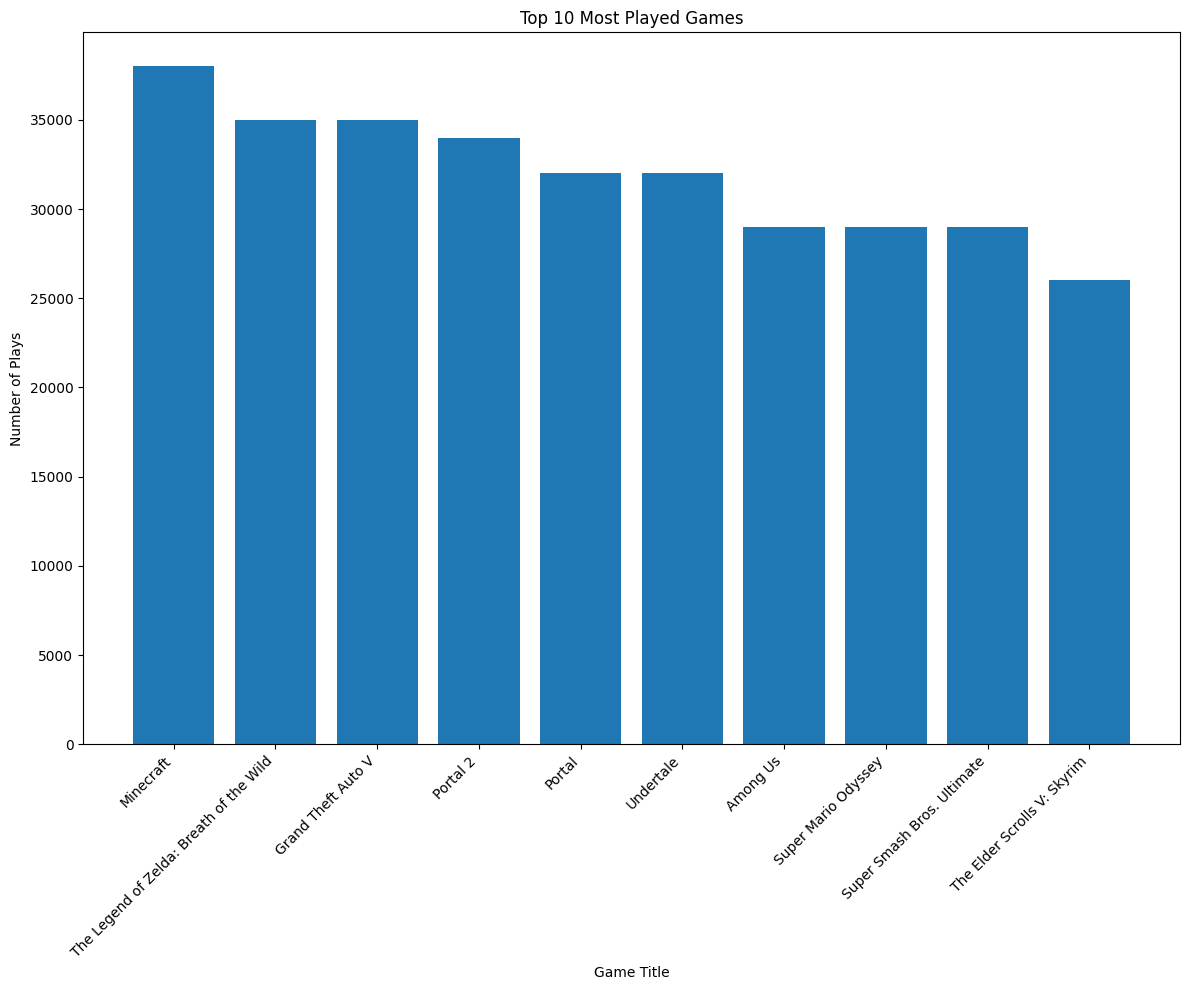

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Datasets/Data/backloggd_games.csv")

plt.figure(figsize=(12, 10))
plt.bar(top_played['Title'], top_played['Cumulative_number_plays'])
plt.title("Top 10 Most Played Games")
plt.xlabel("Game Title")
plt.ylabel("Number of Plays")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
